In [16]:
import uproot as up
import numpy as np
import time
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from multiprocessing import Pool
import multiprocessing
from importlib.machinery import SourceFileLoader

sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen_test')
from D0ToKSpipi2018 import *

Kspipi = PyD0ToKSpipi2018()
Kspipi.init()
print('INFO: Loading the amplitude model')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

INFO: Loading the amplitude modelD0ToKSpipi2018 (Apr 30 2024) ==> Initialization !



In [17]:
index=1
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=index):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0) & (B_M> 5150)'
    if cut == 'm':
        charge = '(Bac_ID<0)& (B_M> 5150)'
       
    array = tree.arrays(branch_names, charge)
    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=index, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)& (B_M> 5150)'
    if cut == 'm':
        charge = '(Bac_ID<0)& (B_M> 5150)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M




config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/%s'%(f'config_cpfit_output_{index}.py')).load_module()
#config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/mass_fit/config/%s'%(f'config_CPrange_input_All.py')).load_module()


In [18]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen')
sys.path.append('/software/pc24403/tfpcbpggsz/core')
from amp import *
from core_test import *
from tfmassshape import *

varDict = config_mass_shape_output.getconfig()
pdfs_mc = {}
s12_mc = {}
s13_mc = {}
Bu_M_mc = {}
Bu_M = {}
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_mc[new_decay], s13_mc[new_decay] = getMass(new_decay, 'int')
        Bu_M_mc[new_decay] = np.linspace(5150, 5800, s12_mc[new_decay].shape[0])
        pdfs_mc[new_decay] = preparePdf_data(Bu_M_mc[new_decay], varDict, decay)


mass_pdfs={}
comps = ['sig', 'misid', 'comb', 'low', 'low_misID', 'low_Bs2DKPi']
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        mass_pdfs[new_decay] = {}
        for comp in comps:
            if decay.split('_')[0] == 'b2dpi' and (comp == 'low_Bs2DKPi' or comp == 'low_misID'): continue
            mass_pdfs[new_decay][comp] = pdfs_mc[new_decay][comp](Bu_M_mc[new_decay])
time2 = time.time()
        
print('INFO: mass Function loaded...')

print('INFO: Loading amplitudes...')

mc_path = '/shared/scratch/pc24403/amp_ampgen'
amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')
amp_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_amp.npy')
ampbar_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_ampbar.npy')
amp_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_amp.npy')
ampbar_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_ampbar.npy')

--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
INFO: mass Function loaded...
INFO: Loading amplitudes...


In [19]:
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        Bu_M[new_decay] = np.linspace(5150, 5800, s12_mc[new_decay].shape[0])


--- INFO: Preparing pdfs for b2dk_DD_p...
--- INFO: Preparing pdfs for b2dk_DD_m...


In [20]:
def prob_dk_dd(x, Bsign=1):

    decay = 'b2dk_DD'
    fracDD = 0.53

    nsig = x[6]*0.5
    nmisid = varDict['n_misid_DK_KsPiPi_DD']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    frac_low_misID = varDict['n_low_misID_DK_KsPiPi_DD']/varDict['n_low_DPi_KsPiPi_DD']
    nlow_misID = varDict['n_low_misID_DK_KsPiPi_DD']*0.5
    nlow_Bs2DKPi = varDict['n_low_Bs2DKPi_DK_KsPiPi_DD']*0.5



    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = 1#(nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)*2
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    comb_normalisation_Bplus = tf.cast((misid_normA_p + misid_normAbar_m)*0.5*fracDD + (1-fracDD), tf.float64)
    comb_normalisation_Bminus = tf.cast((misid_normA_p + misid_normAbar_m)*0.5*fracDD + (1-fracDD), tf.float64)
    low_normalisation_Bplus = tf.cast(misid_normAbar_m, tf.float64)
    low_normalisation_Bminus = tf.cast(misid_normA_p, tf.float64)
    low_Bs2DKPi_normalisation_Bplus = tf.cast(misid_normA_p, tf.float64)
    low_Bs2DKPi_normalisation_Bminus = tf.cast(misid_normAbar_m, tf.float64)

    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p/comb_normalisation_Bplus)+(low_prob_p/low_normalisation_Bplus)+(low_misID_prob_p/low_normalisation_Bplus)+(low_Bs2DKPi_prob_p/low_Bs2DKPi_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m/comb_normalisation_Bminus)+(low_prob_m/low_normalisation_Bminus)+(low_misID_prob_m/low_normalisation_Bminus)+(low_Bs2DKPi_prob_m/low_Bs2DKPi_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p/comb_normalisation_Bplus)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m/comb_normalisation_Bminus)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
    prob_p['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_p/low_Bs2DKPi_normalisation_Bplus)))
    prob_m['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_m/low_Bs2DKPi_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m


In [21]:
def plotOn(data=[], var=[], decay=decay, weights=[], nbins=100, ax=None, range=[5150, 5800]):

    print(var[decay].shape)
    charge_flag = '+'
    if decay[:-1] == 'm':
        charge_flag = '-'
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'low_Bs2DKPi': True}
    scale_factor = 1#len(data[decay].flatten())/sum(weights['total'].numpy().flatten())
    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data[decay], bins=bin_edges)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    #ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')
    #for key in prob.keys():
    #ax.hist(var[decay], bins=100, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=100, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=['comb', 'low', 'misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['comb', 'low', 'low_misID', 'low_Bs2DKPi', 'misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}

    ax.hist([var[decay] for key in keys], bins=100, histtype='step', stacked=False, weights=[(weights[key].numpy().flatten()*scale_factor) for key in keys], label=[key for key in keys], color=[colors[key] for key in keys])


    sum_weights = np.zeros(weights[keys[0]].numpy().shape)
    for key in keys:
        sum_weights += weights[key]
    ax.hist(var[decay], weights=sum_weights.numpy().flatten()*scale_factor, color='red', label='Total',bins=100, histtype='step')
    ax.legend()

    ax.set_xlabel(r'$M(B^{{charge_flag}})$')

In [22]:
x = [-0.0897, -0.05, 0.074, 0.104, -0.057, 0.03, varDict['n_sig_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'],  varDict['n_sig_DPi_KsPiPi_DD'],  varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'],  varDict['n_sig_DK_KsPiPi_LL'],  varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'],  varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']]
prob = prob_dk_dd(x, 1)

In [23]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge)

In [24]:
phase=DeltadeltaD(amp_dk_dd_p, ampbar_dk_dd_p)


In [25]:
def plotOn(data=[], var=[], decay=decay, weights=[], nbins=100, ax=None, range=[5150, 5800]):

    print(var[decay].shape)
    charge_flag = '$M(B^{+})$'
    if decay[:-1] == 'm':
        charge_flag ='$M(B^{-})$'
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'low_Bs2DKPi': True}
    scale = len(data[decay].flatten())

    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data[decay], bins=bin_edges)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    #for key in prob.keys():
    #ax.hist(var[decay], bins=100, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=100, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=['comb', 'low', 'misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['comb', 'low', 'low_misID', 'low_Bs2DKPi', 'misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}

#    ax.hist([var[decay] for key in keys], bins=100, histtype='step', stacked=False, weights=[(weights[key].numpy().flatten()*scale_factor) for key in keys], label=[key for key in keys], color=[colors[key] for key in keys])
    # Your data and weights
    data = [var[decay].flatten() for key in keys]  # Your data here
    weights = [weights[key].numpy().flatten() for key in keys]  # Your weights here
    colors = [colors[key] for key in keys]  # Your colors here
    # Calculate total sum of weights
    total_weight = sum([sum(w) for w in weights])

    # Plot histogram
    hist_values = []
    bins = []

    for data, weight in zip(data, weights):
        a, b, _ = ax.hist(data, bins=100, histtype='step', stacked=False, weights=weight)
        hist_values.append(a)
        bins.append(b)

    # Scale the histogram
    scaling_factor = scale / total_weight  # Calculate the scaling factor
    hist_values_scaled = [hist * scaling_factor for hist in hist_values]  # Scale the histogram values

    #Draw the hist with summing over all weights
    sum_weights = np.zeros(weights[0].shape)
    for i, key in enumerate(keys):
        sum_weights += weights[i]
    a_total, b_total, _ = ax.hist(var[decay], weights=sum_weights, color='red', label='Total',bins=100, histtype='step')
    
    # Clear each axis
    ax.clear()
    ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')

    for hist, bin_edges, color, label in zip(hist_values_scaled, bins, colors, keys):
        # Plot the histogram
        ax.step(bin_edges[:-1], hist, where='post', color=color, label=label)

    

    scaling_factor_total = scale / sum_weights.sum()  # Calculate the scaling factor
    print(scaling_factor_total)
    a_total = a_total * scaling_factor_total

    ax.step(b_total[:-1], a_total, where='post', color='red', label='Total')

    ax.legend()
    
#    sum_weights = np.zeros(weights[keys[0]].numpy().shape)
#    for key in keys:
#        sum_weights += weights[key]
#    ax.hist(var[decay], weights=sum_weights.numpy().flatten()*scale_factor, color='red', label='Total',bins=100, histtype='step')
    ax.set_xlabel(charge_flag)

(811522,)
0.0008071755840595274
(811522,)
0.0008071755840595274
(811522,)
0.0008071755840595274


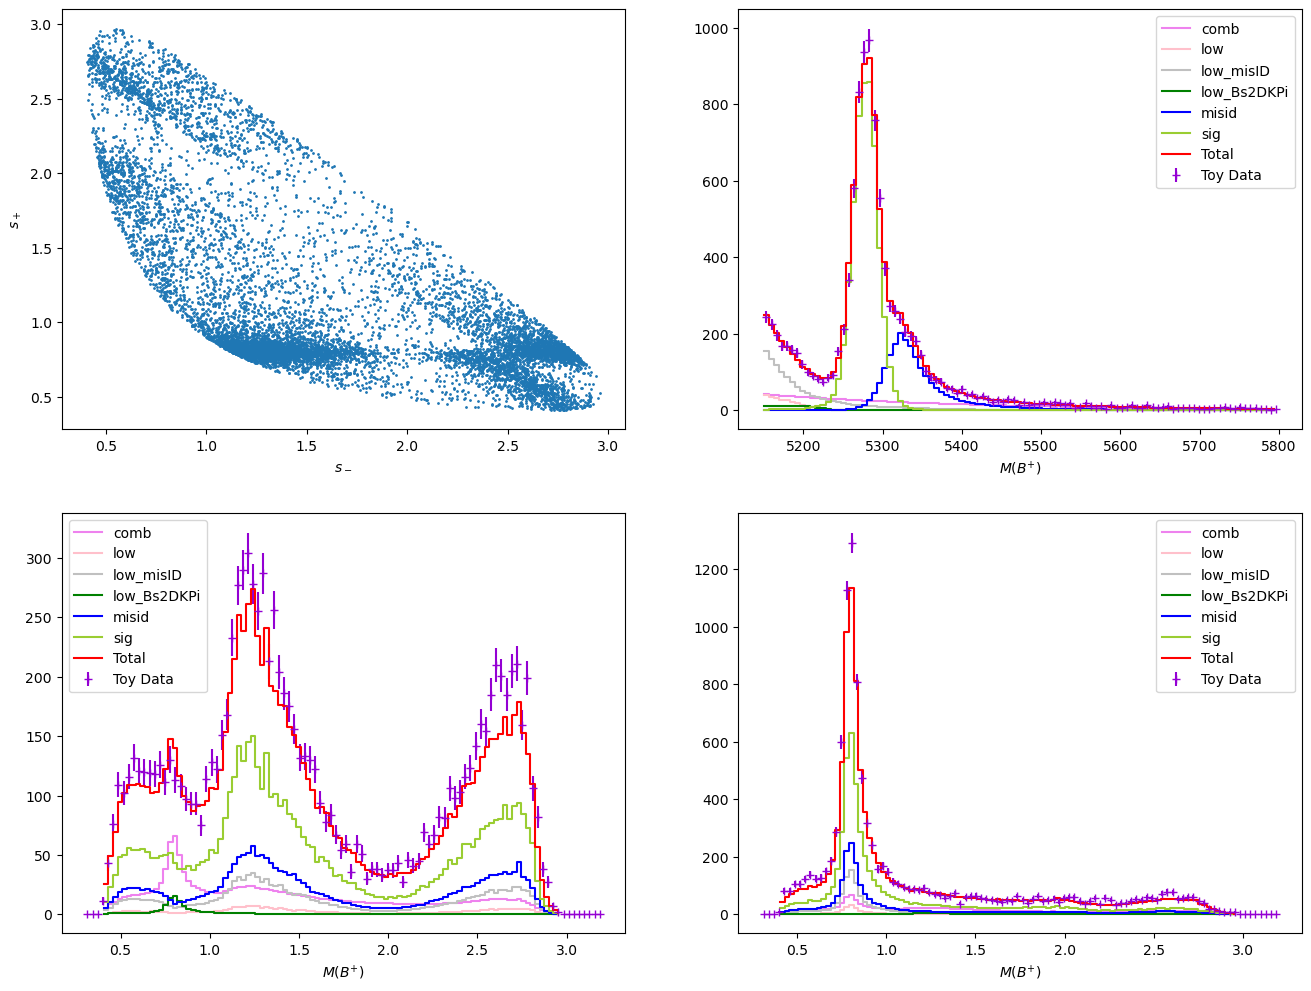

In [26]:
decay = 'b2dk_DD_p'

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data[decay], s13_data[decay], s=1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')



plotOn(data=Bu_M, var=Bu_M_mc, decay=decay, weights=prob, nbins=100, ax=ax1,range=[5150, 5800])
plotOn(data=s12_data, var=s12_mc, decay=decay, weights=prob, nbins=100, ax=ax2, range=[0.3, 3.2])
plotOn(data=s13_data, var=s13_mc, decay=decay, weights=prob, nbins=100, ax=ax3, range=[0.3, 3.2])




plt.show()

(803192,)
0.000807510620160147
(803192,)
0.000807510620160147
(803192,)
0.000807510620160147


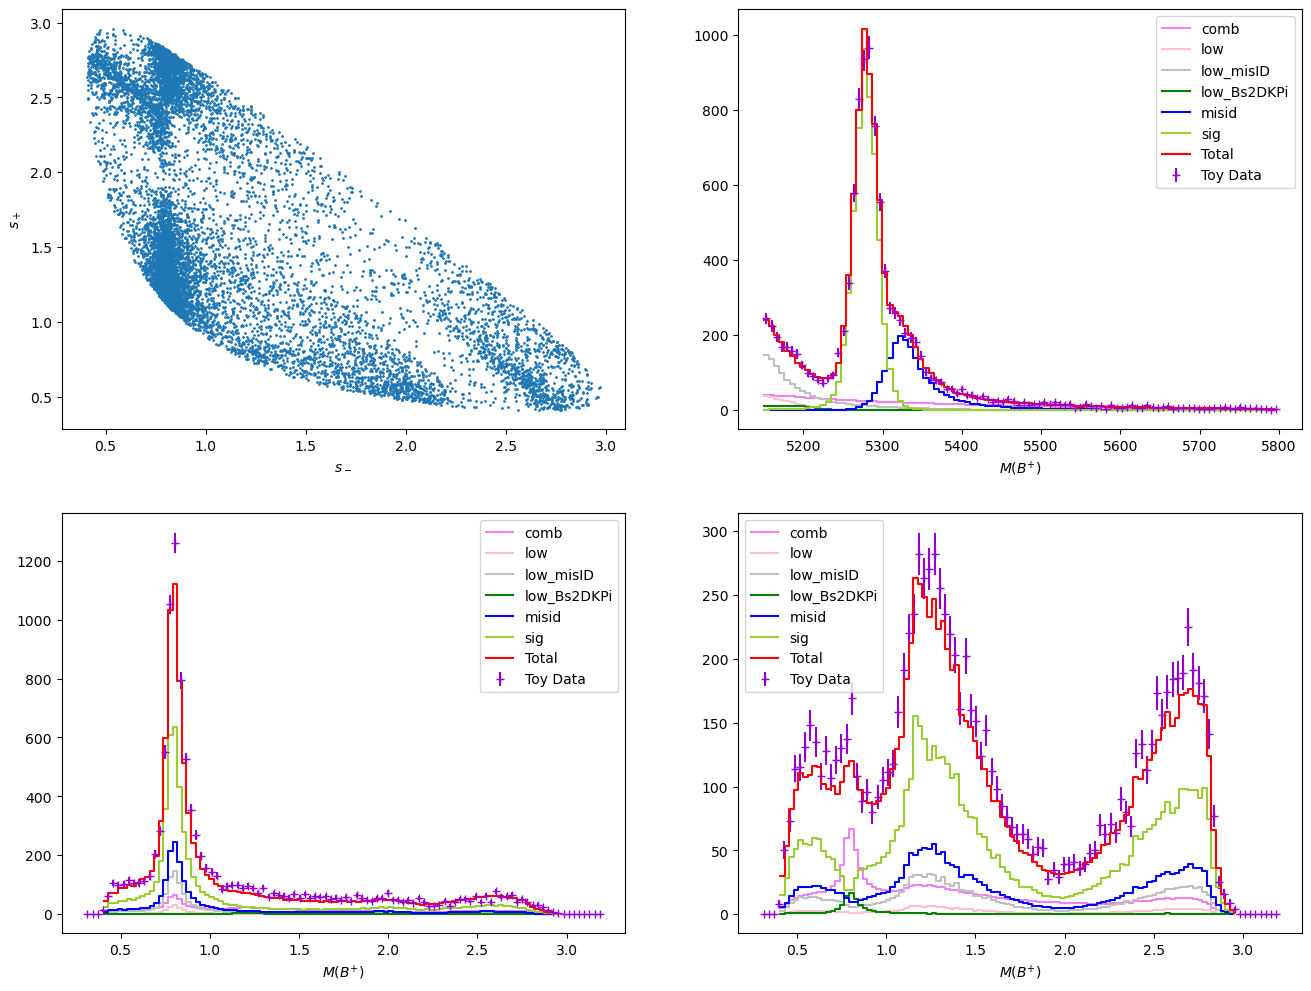

In [27]:
prob = prob_dk_dd(x, -1)
decay = 'b2dk_DD_m'

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data[decay], s13_data[decay], s=1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')



plotOn(data=Bu_M, var=Bu_M_mc, decay=decay, weights=prob, nbins=100, ax=ax1,range=[5150, 5800])
plotOn(data=s12_data, var=s12_mc, decay=decay, weights=prob, nbins=100, ax=ax2, range=[0.3, 3.2])
plotOn(data=s13_data, var=s13_mc, decay=decay, weights=prob, nbins=100, ax=ax3, range=[0.3, 3.2])




plt.show()